In [2]:
import pandas as pd

# 데이터 세트 호출
m_df = pd.read_csv('./datasets/medical_insurance.csv', low_memory=False)
m_df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
2767,47,female,45.320,1,no,southeast,8569.86180
2768,21,female,34.600,0,no,southwest,2020.17700
2769,19,male,26.030,1,yes,northwest,16450.89470
2770,23,male,18.715,0,no,northwest,21595.38229


#### 📊 데이터 전처리

In [3]:
# 중복행 제거
pre_m_df = m_df.drop_duplicates().reset_index(drop=True)

In [4]:
# 타겟 데이터 이상치 제거
from sklearn.preprocessing import StandardScaler

# 표준화 객체 생성
std = StandardScaler()
# 데이터 표준화 변환
result = std.fit_transform(pre_m_df[['charges']])
# 표준화 데이터 프레임 생성
std_pre_m_df = pd.DataFrame(result, columns=['charges'])

# 타겟 데이터 이상치 제거
std_pre_m_df = std_pre_m_df[std_pre_m_df.charges.between(-1.96, 1.96)]

# 이상치 제거후 유지되는 인덱스를 대조하여 원본 데이터 이상치 제거
pre_m_df = pre_m_df.iloc[std_pre_m_df.index].reset_index(drop=True)

In [5]:
# 타겟 컬럼 분포 변환
from sklearn.preprocessing import PowerTransformer

ptf = PowerTransformer(standardize=False)
pre_m_df['charges'] = ptf.fit_transform(pre_m_df[['charges']])

In [6]:
from sklearn.preprocessing import LabelEncoder

# 데이터 프레임 복제
enc_m_df = pre_m_df.copy()
encoders = {}

# 문자열 컬럼 추출
columns = ['sex', 'smoker']

# 반복하여 컬럼 인코딩 처리:
for column in columns:
    # 레이블인코더 객체 생성
    encoder = LabelEncoder()
    # 문자열 데이터 정수로 형변환
    result = encoder.fit_transform(enc_m_df[column])
    # 형변환 값으로 대체
    enc_m_df[column] = result
    # 원본 데이터 담기
    encoders[column] = encoder.classes_

In [7]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# 원 핫 인코더 객체 생성
# sparse_output: False = 밀집행렬(실제 값으로 채워진 행렬) 반환
one_hot_encoder = OneHotEncoder(sparse_output=False)
# 지역 피처 인코딩 처리
result = one_hot_encoder.fit_transform(enc_m_df[['region']])

# 인코딩 값 데이터 프레임으로 생성하고 정수로 형변환한 뒤, 기존 데이터 프레임과 병합
enc_m_df = pd.concat([enc_m_df, pd.DataFrame(result, columns=one_hot_encoder.categories_).astype(np.int8)], axis=1)

# 사용이 끝난 데이터 제거
enc_m_df = enc_m_df.drop(labels='region', axis=1)

# 원 핫 인코딩 컬럼명 변경
enc_m_df.rename(columns={
    ('northeast',): 'northeast',
    ('northwest',): 'northwest',
    ('southeast',): 'southeast',
    ('southwest',): 'southwest',
}, inplace=True)

In [8]:
# 타겟 컬럼 위치 변경을 위해 새로운 컬럼에 데이터 담기
enc_m_df['target'] = enc_m_df.charges
# 기존 컬럼은 제거
enc_m_df = enc_m_df.drop(labels='charges', axis=1)

### 🌟 1Cycle

#### 🚩 1Cycle 결과
- 회귀  
**MSE: 2.0043, RMSE: 1.4158, MSLE: 0.0052, RMSLE: 0.0720, R2: 0.7340**

- 다중 회귀  
**MSE: 2.2306, RMSE: 1.4935, MSLE: 0.0060, RMSLE: 0.0774, R2: 0.7040**

- 회귀 모델(GradientBoostingRegressor)  
**MSE: 1.9586, RMSE: 1.3995, MSLE: 0.0053, RMSLE: 0.0727, R2: 0.7401**

#### 💡 분석
- 회귀 분석 결과 R2 점수가 약 0.76이 나옴에 따라 선형 패턴을 지니고 있다고 보여졌으나,  
  다중 회귀로 곡선을 부여하였을 때 약 R2 점수가 0.82로 상승함에 따라 완전한 선형은 아니고 비선형의 패턴도 띄고 있음을 확인함.
- 회귀 모델 중 GradientBoostingRegressor을 사용하였을 때, 가장 좋은 성능을 보임에 따라 해당 모델을 선택하는 것이 적합하다고 판단됨.

### 🌟 2Cycle

In [9]:
# 피처 제거
columns = ['northeast', 'northwest', 'southeast', 'southwest', 'sex']

enc_m_df = enc_m_df.drop(columns=columns, axis=1)

#### 🚩 1Cycle 결과
- 회귀 모델(GradientBoostingRegressor)  
**MSE: 1.9586, RMSE: 1.3995, MSLE: 0.0053, RMSLE: 0.0727, R2: 0.7401**

#### 🚩 2Cycle 결과
- 전처리 후 회귀 모델(GradientBoostingRegressor)  
**MSE: 2.0182, RMSE: 1.4206, MSLE: 0.0054, RMSLE: 0.0733, R2: 0.7322**

#### 💡 분석
- 상관관계가 낮은 피처 제거 후 성능이 매우 근소한 차이로 저하된 것을 확인하였지만, 다중 공산성을 해결하기 위해 제거하기로 함.
- validation 분리 후 훈련하여 성능평가를 재진행하기로 함.

### 🌟 3Cycle

In [10]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score

def get_evaluation(y_test, prediction):
    MSE = mean_squared_error(y_test, prediction)
    RMSE = np.sqrt(MSE)
    MSLE = mean_squared_log_error(y_test, prediction)
    RMSLE = np.sqrt(MSLE)
    R2 = r2_score(y_test, prediction)
    print('MSE: {:.4f}, RMSE: {:.4f}, MSLE: {:.4f}, RMSLE: {:.4f}, R2: {:.4f}'\
         .format(MSE, RMSE, MSLE, RMSLE, R2))

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

# 데이터 세트 분리
# 피처, 타겟 데이터 분리
features, targets = enc_m_df.iloc[:, :-1], enc_m_df.iloc[:, -1]

# 학습/테스트 및 문제/정답 데이터 세트 분리
X_train, X_test, y_train, y_test = \
train_test_split(features, targets, test_size=0.2, random_state=124)

# 가장 성능으로 높았던 모델 가져오기
cv_gb_r = GradientBoostingRegressor(random_state=124)

# 파라미터 값 조정
parameters = {'max_depth': [3, 4, 5], 'min_samples_split': [50, 60, 70], 'n_estimators': [40, 50, 60]}

# 하이퍼 파라미터 조정
grid_cv_gb_r = GridSearchCV(cv_gb_r, param_grid=parameters, cv=5, n_jobs=-1)

# 훈련
grid_cv_gb_r.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=124),
             n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5],
                         'min_samples_split': [50, 60, 70],
                         'n_estimators': [40, 50, 60]})

In [12]:
# 최적의 모델 담기
cv_gb_r = grid_cv_gb_r.best_estimator_

# 예측
prediction = cv_gb_r.predict(X_test)
# 평가
get_evaluation(y_test, prediction)

MSE: 1.8219, RMSE: 1.3498, MSLE: 0.0048, RMSLE: 0.0694, R2: 0.7583


#### 🚩 2Cycle 결과
- 전처리 후 회귀 모델(GradientBoostingRegressor)  
**MSE: 2.0182, RMSE: 1.4206, MSLE: 0.0054, RMSLE: 0.0733, R2: 0.7322**
  
#### 🚩 3Cycle 결과
- Validation (cv)  
**MSE: 1.8219, RMSE: 1.3498, MSLE: 0.0048, RMSLE: 0.0694, R2: 0.7583**

- Validation (K-Fold)  
**MSE: 1.8234, RMSE: 1.3503, MSLE: 0.0048, RMSLE: 0.0694, R2: 0.7581**

#### 💡 분석
- validation 후 성능이 더 향상된 것으로 나타났으며, 5-폴드보다 k-폴드의 성능이 근소한 차이로 열세한 것으로 나타남.
- 차원 축소 시 성능이 어떻게 조정되는지 확인하기로 함.

### 🌟 4Cycle

#### 🚩 3Cycle 결과
- Validation (cv)  
**MSE: 1.8219, RMSE: 1.3498, MSLE: 0.0048, RMSLE: 0.0694, R2: 0.7583**

#### 🚩 4Cycle 결과
- 차원축소 (3차원)  
**MSE: 4.9929, RMSE: 2.2345, MSLE: 0.0133, RMSLE: 0.1154, R2: 0.3375**

#### 💡 분석
- 차원 축소 시 성능이 훨씬 저하된다는 것을 확인함.
- 정규화 추가 진행 후 성능이 어떻게 변화하는지 더 확인해 보기로 함.

### 🌟 5Cycle

#### 🚩 3Cycle 결과
- Validation (cv)  
**MSE: 1.8219, RMSE: 1.3498, MSLE: 0.0048, RMSLE: 0.0694, R2: 0.7583**

#### 🚩 4Cycle 결과
- 차원축소 (3차원)  
**MSE: 4.9929, RMSE: 2.2345, MSLE: 0.0133, RMSLE: 0.1154, R2: 0.3375**

#### 🚩 5Cycle 결과
- 정규화 처리 후 차원축소 (3차원)  
**MSE: 2.1718, RMSE: 1.4737, MSLE: 0.0060, RMSLE: 0.0773, R2: 0.7118**

#### 💡 분석
- 전처리 후 성능이 더 향상은 되었으나, 차원 축소 전 성능이 훨씬 우세하다는 것을 확인함.
- 0.8 이상은 과적합이 우려되기 때문에 규제를 별도로 더 진행하기로 함.

### 🌟 6Cycle
- 과적합 확인

In [12]:
from sklearn.model_selection import cross_val_score

# 최적의 모델
kf_gb_r = GradientBoostingRegressor(random_state=124)
# 교차검증
# kfold = KFold(n_splits=10, random_state=124, shuffle=True)

# 점수 확인
score = cross_val_score(kf_gb_r, features, targets, cv=5)
score

array([0.80204897, 0.63875831, 0.82327965, 0.75586881, 0.72240703])

MSE: 2.0399, RMSE: 1.4283, MSLE: 0.0051, RMSLE: 0.0716, R2: 0.7876


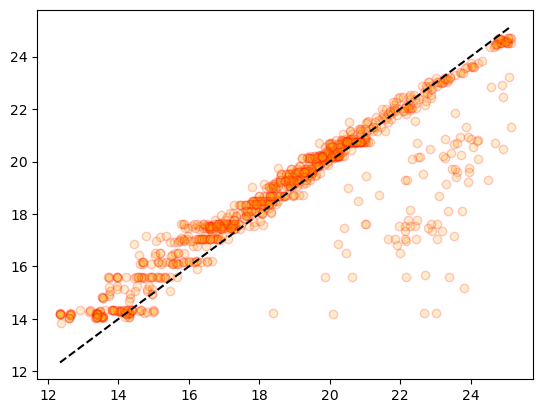

In [13]:
import matplotlib.pyplot as plt

cv_gb_r.fit(X_train, y_train)
prediction = cv_gb_r.predict(X_train)
get_evaluation(y_train, prediction)

fig, ax = plt.subplots()
ax.scatter(y_train, prediction, edgecolors='red', c='orange', alpha=0.2)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--')
plt.show()

MSE: 1.3312, RMSE: 1.1538, MSLE: 0.0035, RMSLE: 0.0595, R2: 0.8234


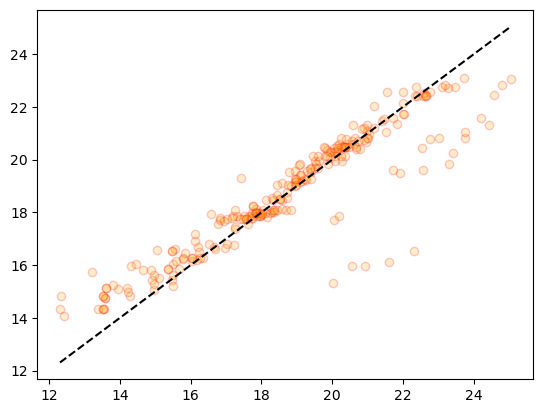

In [14]:
import matplotlib.pyplot as plt

cv_gb_r.fit(X_test, y_test)
prediction = cv_gb_r.predict(X_test)
get_evaluation(y_test, prediction)

fig, ax = plt.subplots()
ax.scatter(y_test, prediction, edgecolors='red', c='orange', alpha=0.2)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.show()

In [15]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("RMSE", fontsize=14)   

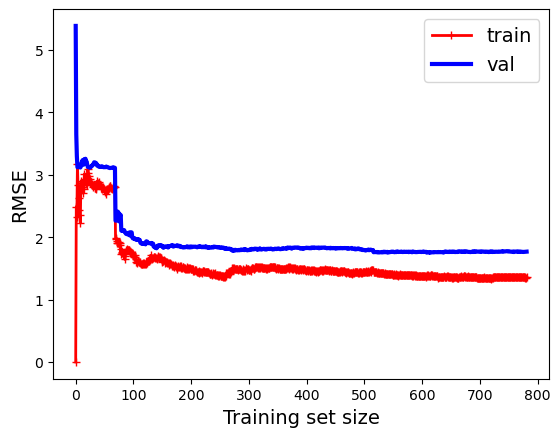

In [16]:
plot_learning_curves(cv_gb_r, X_train, y_train)

In [40]:
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

features, targets = enc_m_df.iloc[:, :-1], enc_m_df.iloc[:, -1]

poly_features = PolynomialFeatures(degree=2).fit_transform(features)

X_train, X_test, y_train, y_test = \
train_test_split(features, targets, test_size=0.2, random_state=124)

lasso = Lasso(alpha=10, max_iter=10000)

lasso.fit(X_train, y_train)

Lasso(alpha=10, max_iter=10000)

In [41]:
prediction = lasso.predict(X_test)
get_evaluation(y_test, prediction)

MSE: 5.4420, RMSE: 2.3328, MSLE: 0.0148, RMSLE: 0.1218, R2: 0.2779


In [47]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

features, targets = enc_m_df.iloc[:, :-1], enc_m_df.iloc[:, -1]

X_trian, X_test, y_trian, y_test = \
train_test_split(features, targets, test_size=0.2, random_state=124)

ridge = Ridge(alpha=1e+1, max_iter=10000)
ridge.fit(X_train, y_train)

Ridge(alpha=10.0, max_iter=10000)

In [48]:
prediction = ridge.predict(X_test)
get_evaluation(y_test, prediction)

MSE: 2.0125, RMSE: 1.4186, MSLE: 0.0053, RMSLE: 0.0728, R2: 0.7330


MSE: 3.0788, RMSE: 1.7547, MSLE: 0.0076, RMSLE: 0.0872, R2: 0.6794


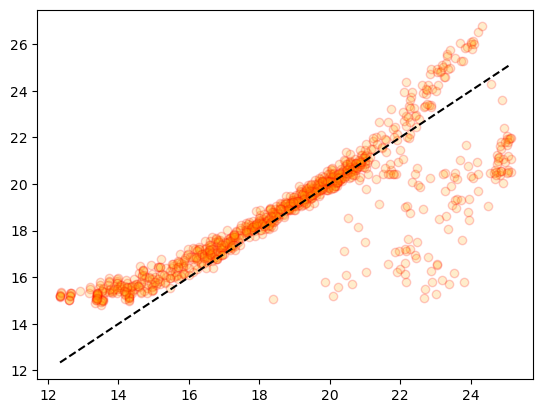

In [49]:
import matplotlib.pyplot as plt

ridge.fit(X_train, y_train)
prediction = ridge.predict(X_train)
get_evaluation(y_train, prediction)

fig, ax = plt.subplots()
ax.scatter(y_train, prediction, edgecolors='red', c='orange', alpha=0.2)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--')
plt.show()

MSE: 2.2223, RMSE: 1.4907, MSLE: 0.0058, RMSLE: 0.0759, R2: 0.7051


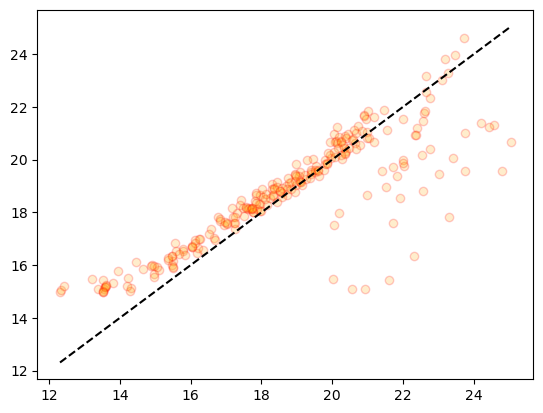

In [50]:
import matplotlib.pyplot as plt

ridge.fit(X_test, y_test)
prediction = ridge.predict(X_test)
get_evaluation(y_test, prediction)

fig, ax = plt.subplots()
ax.scatter(y_test, prediction, edgecolors='red', c='orange', alpha=0.2)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.show()